In [1]:
# user-friendly print
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
from KRFD_helper import plot_prediction_pairs, swap_train_val_split  # add other needed names here
from KRFD_model import KernelRegression, ModelConfig
from KRFD_utils import DOSDataModule, init_centers_and_sigmas
from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, TensorBoardLogger
from sklearn.metrics import mean_absolute_error, r2_score

InteractiveShell.instance().ast_node_interactivity = "all"

torch.set_float32_matmul_precision("medium")  # 推荐选项

In [2]:
import joblib
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250615.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250615.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250615.pd.parquet")

/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.7.0 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/foundation_model/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.0 when using v

In [3]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

# OUTLIER = 1400
OUTLIER = None
prop_name = _[4]

prop_value = qc_ac_te_mp_dos_data[prop_name].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop_name} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop_name} (T/K)"].loc[prop_value.index]
    if prop_name != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)

if OUTLIER is not None and OUTLIER:
    # Remove entries where any value in prop_T > 270 (remove whole sample if any t > 270)
    mask = prop_T.apply(lambda arr: np.all(np.asarray(arr) <= OUTLIER))
    prop_value = prop_value[mask]
    prop_value_norm = prop_value_norm[mask]
    prop_T = prop_T[mask]

serial_name = "Temperature (K)" if prop_name != "DOS density" else r"$E - E_{ferim}$ (eV)"
desc = desc_trans.loc[prop_value.index]


In [4]:
# -------------------------
# Configuration and training setup
# -------------------------
EPOCHS = 200
N_TRY = 5
BATCH_SIZE = 2048
TRAIN_RATIO = 0.4  # use 1.0 to train on all training data
DEVICE_NUM = 1

# Number of Gaussian kernels
# Note: this is a hyperparameter that can be tuned based on the dataset.
# More kernels can capture more complex patterns, but may also lead to overfitting.
# If you want to use a different number of kernels, change this value.
# For example, you can set N_KERNEL = 50 or N_KERNEL = 20 to see how it affects performance.
# The default value is 30, which is a good starting point for many datasets.
N_KERNEL = 10

# Learning rate and decay for the main model branches (μ1(X), μ2(t))
# Note: these are the global learning rate and decay for the main branches.
# If you want to use a different lr/decay for β(X) or μ3(X,t), set them explicitly in the config.
LR_RATE = 5e-4
# LR_RATE = 1e-3
OTHER_DECAY = 5e-5

# Learning rate and decay for β(X) branch
# Note: β(X) has a different learning rate and decay from the rest of the model.
# This is to ensure it can adapt independently, especially if it has a different scale.
# If you want to use the same lr/decay for β(X), set `beta_lr=None` and `beta_weight_decay=other_weight_decay`.
BETA_LR_RATE = 5e-4
# BETA_LR_RATE = 3e-4
# BETA_DECAY = 1e-4  # specific to β(X)
BETA_DECAY = 0  # specific to β(X)

# Learning rate and decay for μ3(X,t) branch
# If you want to use the same lr/decay for μ3(X,t) as the rest of the model, set `mu3_lr=None` and `mu3_weight_decay=other_weight_decay`.
# If you want a different lr/decay for μ3(X,t), set them explicitly.
MU3_LR_RATE = None  # inherit from `lr` if None
MU3_DECAY = None  # inherit from `other_weight_decay` if None

x_dim = desc.shape[1]
t_range = (prop_T.iloc[0].min(), prop_T.iloc[0].max())

cfg = ModelConfig(
    prop_name=prop_name,
    x_dim=x_dim,
    # kernel options
    n_kernels=N_KERNEL,
    learnable_centers=True,
    learnable_sigmas=True,
    # β(X) branch
    beta_hidden=(128, 64),
    beta_activation="gelu",
    beta_dropout=0.0,
    beta_batchnorm=False,
    beta_weight_decay=BETA_DECAY,  # regularization (decoupled L2 via AdamW) specific to β(X)
    beta_lr=BETA_LR_RATE,  # DIFFERENT lr for β(X); set None to inherit `lr`
    # μ1(X) branch
    mu1_hidden=(128, 64),
    mu1_activation="gelu",
    mu1_dropout=0.0,
    mu1_batchnorm=False,
    # μ2(t) branch
    mu2_hidden=(16, 8),
    mu2_activation="gelu",
    mu2_dropout=0.0,
    mu2_batchnorm=False,
    # μ3(X,t) branch
    enable_mu3=False,  # set to False to disable μ3(X,t) branch
    mu3_hidden=(128, 64),
    mu3_activation="gelu",
    mu3_dropout=0.0,
    mu3_batchnorm=False,
    mu3_lr=MU3_LR_RATE,  # inherit `lr` (change if you want a custom μ3 lr)
    mu3_weight_decay=MU3_DECAY,  # inherit `other_weight_decay` (or set a custom value)
    # other/global lr & decay
    other_weight_decay=OTHER_DECAY,  # default for others
    lr=LR_RATE,  # global lr for others
)


centers: tensor([1.0000e+00, 1.4556e+02, 2.9011e+02, 4.3467e+02, 5.7922e+02, 7.2378e+02,
        8.6833e+02, 1.0129e+03, 1.1574e+03, 1.3020e+03])
sigmas : tensor([86.7333, 86.7333, 86.7333, 86.7333, 86.7333, 86.7333, 86.7333, 86.7333,
        86.7333, 86.7333])


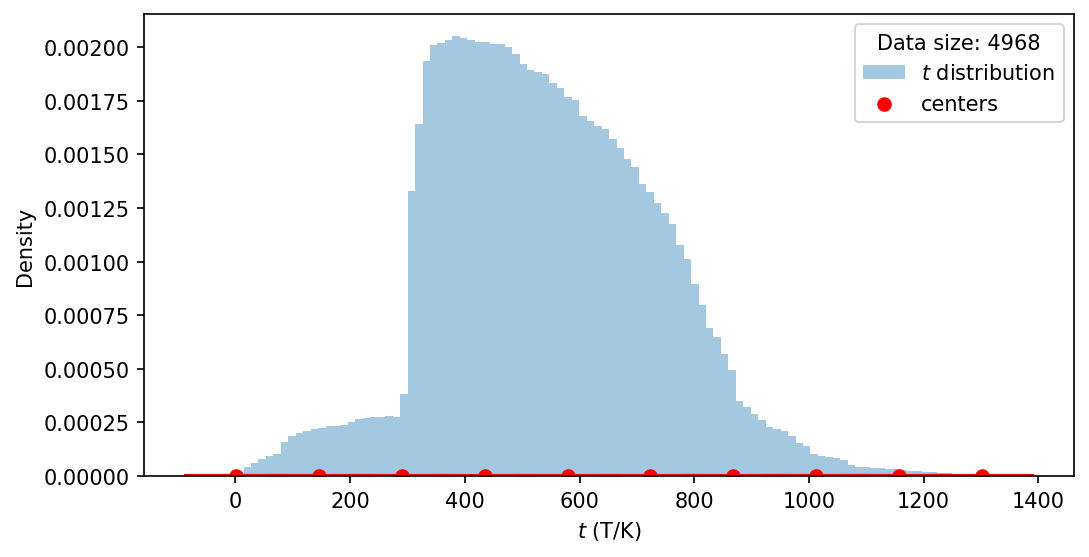

In [5]:
# initialize centers/sigmas from training t distribution


t_train = np.concatenate(prop_T.values)
t_range = (t_train.min(), t_train.max())  # ensure t_range is based on training data


centers, sigmas = init_centers_and_sigmas(
    # t_train=t_train,
    t_train=None,
    n_kernels=N_KERNEL,
    method="quantile",  # or 'hist' / 'kmeans'
    sigma_alpha=(t_train.max() - t_train.min()) / N_KERNEL / 1.5,  # spacing to sigma
    # sigma_alpha=1.0,  # spacing to sigma
    t_range=t_range,
)

print("centers:", centers)
print("sigmas :", sigmas)

# 绘制分布和 centers/sigmas
_ = plt.figure(figsize=(8, 4), dpi=150)
_ = plt.hist(t_train, bins=100, density=True, alpha=0.4, label=r"$t$ distribution")

centers_np = centers.numpy()
sigmas_np = sigmas.numpy()

# plot centers and sigmas
_ = plt.scatter(centers_np, np.zeros_like(centers_np), color="red", label="centers")
for c, s in zip(centers_np, sigmas_np):
    _ = plt.plot([c - s, c + s], [0, 0], color="red", lw=2)


if OUTLIER is not None and OUTLIER:
    _ = plt.text(
        0.98,
        0.98,
        f"Data size: {len(prop_T)}",
        ha="right",
        va="top",
        transform=plt.gca().transAxes,
        fontsize=20,
    )

    # _ = plt.legend(None)
else:
    # labels and title
    _ = plt.xlabel(r"$t$ (T/K)")
    _ = plt.ylabel("Density")
    # _ = plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    # _ = plt.title(r"Centers and sigmas initialized from $t$ distribution")
    _ = plt.legend(title=f"Data size: {len(prop_T)}")
_ = plt.show()

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Experiment 1: Fourier feature encoding ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | kernel   | GaussianKernel | 20     | train
1 | beta_net | Sequential     | 46.2 K | train
2 | mu1_net  | Sequential     | 45.6 K | train
3 | mu2_net  | Sequential     | 177    | train
4 | mae      | L1Loss         | 0      | train
5 | mse      | MSELoss        | 0      | train
----------------------------------------------------
91.9 K    Trainable params
0         Non-trainable params
91.9 K    Total params
0.368     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 53: 100%|██████████| 204/204 [00:07<00:00, 28.42it/s, v_num=al_1, val_mse=0.655, val_mae=0.613, train_loss=0.367]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 110/110 [00:00<00:00, 218.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 204/204 [00:00<00:00, 226.34it/s]
plot_prediction_pairs indices: [654, 114, 25, 281, 250, 228, 142, 104, 692]
Saved figure to logs/kernel_regression/ZT/0903_0236_nk10_r0.4/predictions/trial_1/test_paris.png


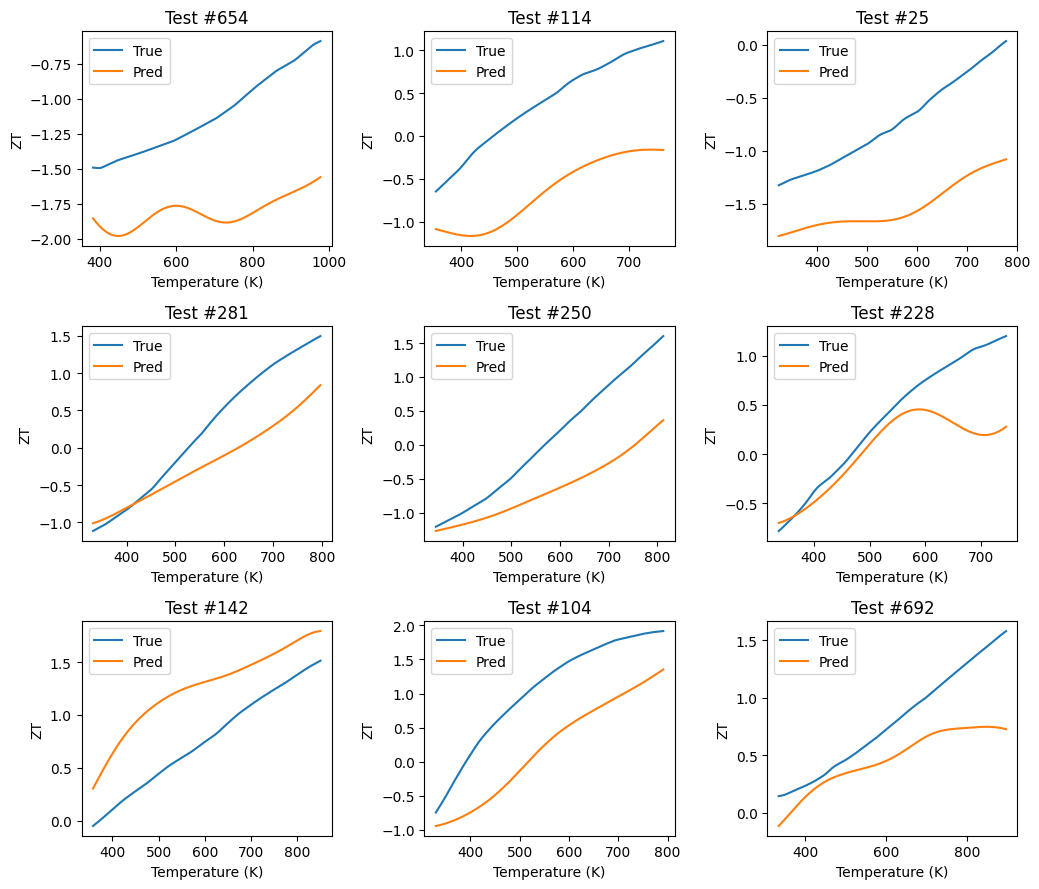

plot_prediction_pairs indices: [1309, 228, 51, 563, 501, 457, 285, 209, 1385]
Saved figure to logs/kernel_regression/ZT/0903_0236_nk10_r0.4/predictions/trial_1/train_paris.png


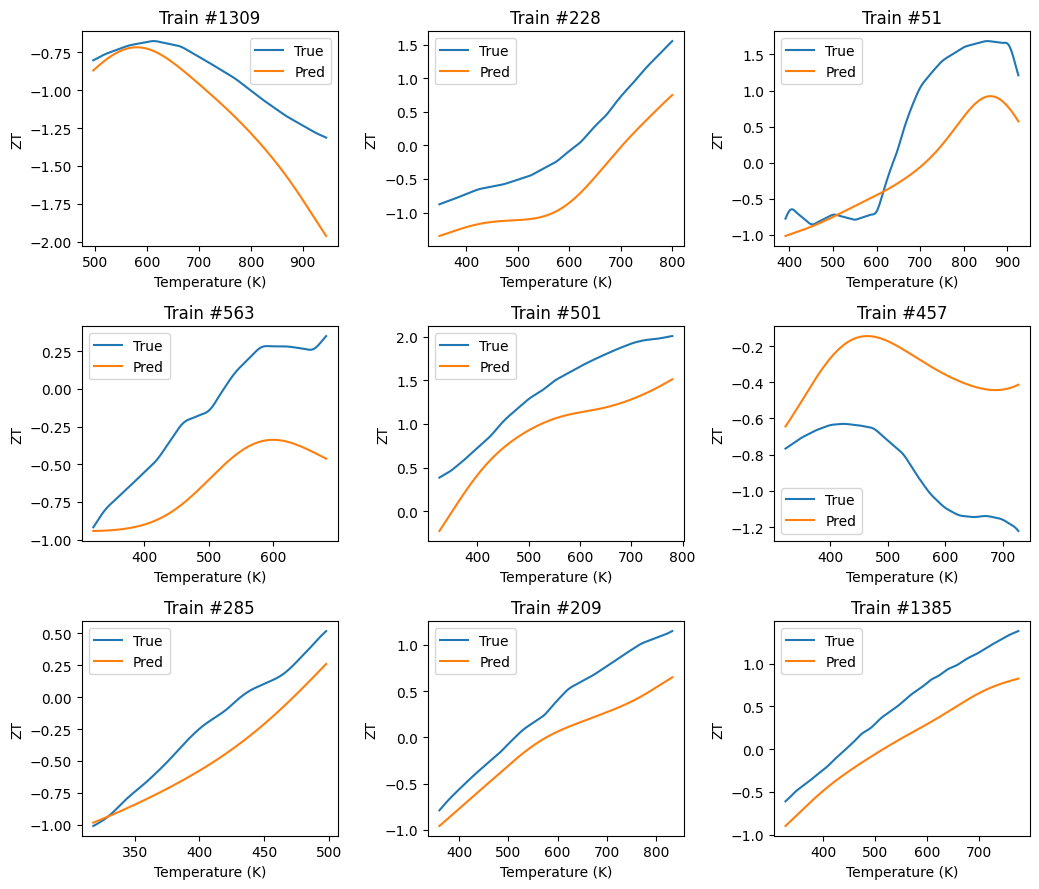

Text(0.5, 0, 'Observation')

Text(0, 0.5, 'Prediction')

Text(0.5, 1.0, 'ZT (normalized)')

Text(0.05, 0.95, 'MAE=0.588\nR²=0.424')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name     | Type           | Params | Mode 
----------------------------------------------------
0 | kernel   | GaussianKernel | 20     | train
1 | beta_net | Sequential     | 46.2 K | train
2 | mu1_net  | Sequential     | 45.6 K | train
3 | mu2_net  | Sequential     | 177    | train
4 | mae      | L1Loss         | 0      | train
5 | mse      | MSELoss        | 0      | train
----------------------------------------------------
91.9 K    Trainable params
0         Non-trainable params
91.9 K    Total params
0.368     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 27:  11%|█         | 23/206 [00:00<00:04, 45.54it/s, v_num=al_2, val_mse=0.710, val_mae=0.629, train_loss=0.430]  

In [ ]:
import json

# Experiment 1: Use Fourier features
print("\n--- Experiment 1: Fourier feature encoding ---")
_ = seed_everything(2025)

if OUTLIER is not None and OUTLIER:
    base_dir = Path(
        f"logs/kernel_regression/{prop_name}/{datetime.now().strftime('%m%d_%H%M')}_nk{N_KERNEL}_c{OUTLIER}_r{TRAIN_RATIO}"
    )
else:
    base_dir = Path(
        f"logs/kernel_regression/{prop_name}/{datetime.now().strftime('%m%d_%H%M')}_nk{N_KERNEL}_r{TRAIN_RATIO}"
    )
for n_try in range(N_TRY):
    # 1. Setup logging directory
    version = f"trial_{n_try + 1}"
    save_dir = base_dir / "predictions" / version
    save_dir.mkdir(parents=True, exist_ok=True)

    # Data split
    split = swap_train_val_split(qc_ac_te_mp_dos_data, swap_ratio=0.8, random_seed=None)
    split = split.loc[prop_value.index]
    _ = split.to_csv(f"{save_dir}/data_split.csv")

    dm = DOSDataModule(
        descriptor=desc,
        dos_energy=prop_T,
        dos=prop_value_norm,
        serial=split,
        batch_size=BATCH_SIZE,
        train_ratio=TRAIN_RATIO,
        random_seed=42,
    )

    # model
    model = KernelRegression(cfg, kernel_centers=centers, kernel_sigmas=sigmas)

    callbacks = [
        EarlyStopping(monitor="val_mse", mode="min", patience=30),
        ModelCheckpoint(monitor="val_mse", mode="min", save_top_k=1, filename="best-{epoch:02d}-{val_mse:.4f}"),
        LearningRateMonitor(logging_interval="epoch"),
    ]
    logger = [
        CSVLogger(base_dir, version=version, name="csv"),
        TensorBoardLogger(base_dir, version=version, name="tensorboard"),
    ]

    trainer = Trainer(
        max_epochs=EPOCHS,
        accelerator="auto",
        devices=[DEVICE_NUM],
        deterministic=True,
        log_every_n_steps=10,
        callbacks=callbacks,
        logger=logger,
    )

    # 4. Start training
    trainer.fit(model, datamodule=dm)

    # 5. Predict
    test_pred = trainer.predict(model, dataloaders=dm.test_dataloader())
    train_pred = trainer.predict(model, dataloaders=dm.train_dataloader())

    # 6. Plot predictions
    all_t = []
    all_v = []
    all_y_hat = []

    if test_pred is not None:
        for batch in test_pred:
            t, v, y_hat = batch
            all_t.append(t)
            all_v.append(v)
            all_y_hat.append(y_hat)
        all_t = torch.cat(all_t, dim=0)
        all_v = torch.cat(all_v, dim=0)
        all_y_hat = torch.cat(all_y_hat, dim=0)
        y_true = all_v.squeeze(-1).cpu().numpy()
        y_preds = all_y_hat.squeeze(-1).cpu().numpy()
        y_t = all_t.squeeze(-1).cpu().numpy()

        # Assume each D corresponds to a sequence length of 300
        seq_len = 300
        num_samples = all_t.shape[0] // seq_len

        samples = []
        for i in range(num_samples):
            t_seq = all_t[i * seq_len : (i + 1) * seq_len]
            v_seq = all_v[i * seq_len : (i + 1) * seq_len]
            y_hat_seq = all_y_hat[i * seq_len : (i + 1) * seq_len]
            samples.append((t_seq, v_seq, y_hat_seq))
        plot_prediction_pairs(
            samples,
            n=9,
            title_prefix="Test",
            prop_name=prop_name,
            serial_name=serial_name,
            show_pred=True,
            save_dir=f"{save_dir}/test_paris.png",
        )

    # 7. Plot predictions
    all_t = []
    all_v = []
    all_y_hat = []

    if train_pred is not None:
        for batch in train_pred:
            t, v, y_hat = batch
            all_t.append(t)
            all_v.append(v)
            all_y_hat.append(y_hat)
        all_t = torch.cat(all_t, dim=0)
        all_v = torch.cat(all_v, dim=0)
        all_y_hat = torch.cat(all_y_hat, dim=0)
        y_fit_true = all_v.squeeze(-1).cpu().numpy()
        y_fit_preds = all_y_hat.squeeze(-1).cpu().numpy()
        y_fit_t = all_t.squeeze(-1).cpu().numpy()

        # Assume each D corresponds to a sequence length of 300
        seq_len = 300
        num_samples = all_t.shape[0] // seq_len

        samples = []
        for i in range(num_samples):
            t_seq = all_t[i * seq_len : (i + 1) * seq_len]
            v_seq = all_v[i * seq_len : (i + 1) * seq_len]
            y_hat_seq = all_y_hat[i * seq_len : (i + 1) * seq_len]
            samples.append((t_seq, v_seq, y_hat_seq))
        plot_prediction_pairs(
            samples,
            n=9,
            title_prefix="Train",
            prop_name=prop_name,
            serial_name=serial_name,
            show_pred=True,
            save_dir=f"{save_dir}/train_paris.png",
        )

        # Concatenate arrays and create DataFrame
        df = pd.DataFrame(
            {
                "ture": np.concatenate([y_true, y_fit_true]),
                "prediction": np.concatenate([y_preds, y_fit_preds]),
                "t": np.concatenate([y_t, y_fit_t]),
                "label": ["prediction"] * len(y_true) + ["fit"] * len(y_fit_true),
            }
        )

        # Save as CSV
        csv_path = f"{save_dir}/results.csv"
        df.to_csv(csv_path, index=False)

        # Save as Parquet
        parquet_path = f"{save_dir}/results.parquet"
        df.to_parquet(parquet_path, index=False)

    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

    ax.scatter(y_fit_true, y_fit_preds, alpha=0.05, label="Train")
    ax.scatter(y_true, y_preds, alpha=0.3, label="Test")
    ax.set_xlabel("Observation")
    ax.set_ylabel("Prediction")
    ax.set_title(f"{prop_name} (normalized)")
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
    mae = mean_absolute_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)
    ax.legend()
    ax.text(
        0.05,
        0.95,
        f"MAE={mae:.3f}\nR²={r2:.3f}",
        transform=ax.transAxes,
        verticalalignment="top",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

    metrics = {"mae": float(mae), "r2": float(r2)}
    with open(f"{save_dir}/metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)
    fig.savefig(f"{save_dir}/scatter.png", bbox_inches="tight")
